In [1]:
t_end = 'Now'
duration_in_day = 5

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


Resolved time range: 2026-02-18 13:20:34.542 -> 2026-02-23 13:20:34.542


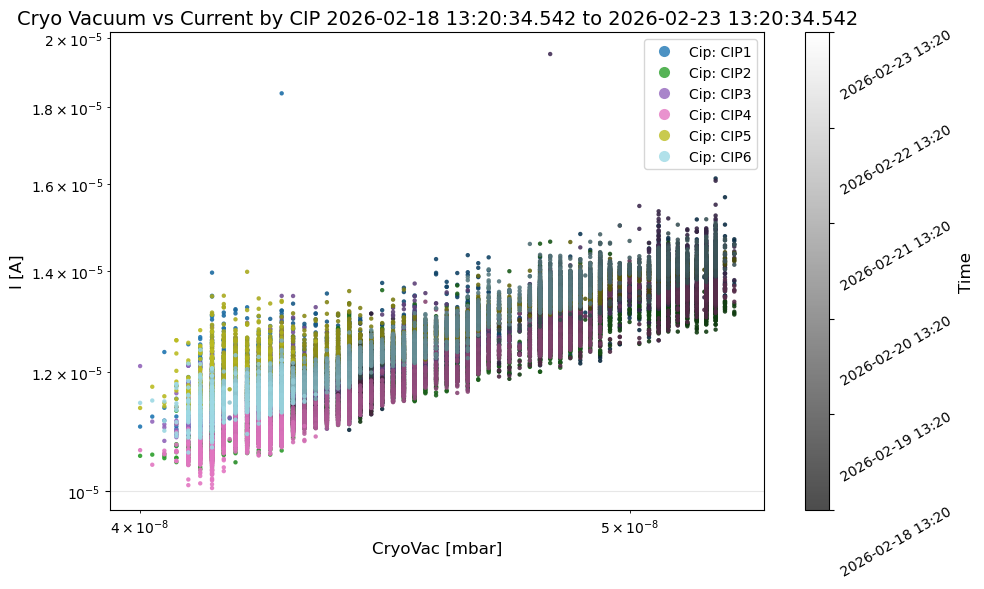

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lsst_efd_client import EfdClient
from astropy.time import Time, TimeDelta
from matplotlib import colors as mcolors
from matplotlib.lines import Line2D

OFFSET = {
    "CIP1": -0.003171139293246799,
    "CIP2": -0.00802408324347602,
    "CIP3": -0.006236367755466037,
    "CIP4": 0.004754777307863589,
    "CIP5": -0.006450745794508193,
    "CIP6": 0.009414226920516402
}
BIN_INFLUX = "1m"
BIN_PANDAS = "1min"
CRYOVAC_TORR_TO_MBAR = 1.3333
CURRENT_MA_TO_A = 1e-3

client = EfdClient("usdf_efd")

def resolve_time_range(t_end_value, duration_days):
    t_end_str = str(t_end_value).strip()
    t_end_val = Time.now() if t_end_str.lower() == "now" else Time(t_end_str)
    t_start_val = t_end_val - TimeDelta(duration_days, format="jd")
    return t_start_val, t_end_val

def result_to_df(result):
    if isinstance(result, pd.DataFrame):
        return result
    if isinstance(result, dict):
        return list(result.values())[0] if result else pd.DataFrame()
    if isinstance(result, list):
        return result[0] if result else pd.DataFrame()
    return pd.DataFrame()

def ensure_datetime_index(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.copy()
        df.index = pd.to_datetime(df.index)
    return df

async def load_vacuum_data(efd_client, start_time, end_time):
    if getattr(efd_client, "influx_client", None) is not None:
        query1 = f"""SELECT mean("CryoVac") AS "mean_CryoVac" FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.vacuum_cryo" 
        WHERE time > '{start_time.iso}' AND time < '{end_time.iso}' 
        GROUP BY time({BIN_INFLUX}) FILL(null)"""
        query2 = f"""SELECT mean("I") AS "mean_I" FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.vacuum_cryo_cip" 
        WHERE time > '{start_time.iso}' AND time < '{end_time.iso}' 
        GROUP BY time({BIN_INFLUX}), "Cip" FILL(null)"""

        result1 = await efd_client.influx_client.query(query1)
        result2 = await efd_client.influx_client.query(query2)

        df1 = result_to_df(result1).rename(columns={"mean_CryoVac": "CryoVac"})
        if isinstance(result2, dict):
            dfs_list = [df for df in result2.values() if isinstance(df, pd.DataFrame) and not df.empty]
            df2 = pd.concat(dfs_list) if dfs_list else pd.DataFrame()
        else:
            df2 = result_to_df(result2)
        df2 = df2.rename(columns={"mean_I": "I"})
        return df1, df2

    print("influx_client is None; using select_time_series fallback")
    df1_raw = await efd_client.select_time_series(
        topic_name="lsst.MTCamera.vacuum_cryo",
        fields=["CryoVac"],
        start=start_time,
        end=end_time,
    )
    df2_raw = await efd_client.select_time_series(
        topic_name="lsst.MTCamera.vacuum_cryo_cip",
        fields=["I", "Cip"],
        start=start_time,
        end=end_time,
    )

    df1 = ensure_datetime_index(df1_raw)[["CryoVac"]].resample(BIN_PANDAS).mean()
    df2 = ensure_datetime_index(df2_raw)
    if "I" not in df2.columns or "Cip" not in df2.columns:
        raise KeyError(f"Fallback query missing columns. Available: {list(df2.columns)}")
    df2 = (
        df2[["Cip", "I"]]
        .dropna(subset=["Cip"])
        .groupby([pd.Grouper(freq=BIN_PANDAS), "Cip"])["I"]
        .mean()
        .reset_index()
        .set_index("time")
    )
    return df1, df2

t_start_val, t_end_val = resolve_time_range(t_end, duration_in_day)
t_start = t_start_val.iso
t_end_iso = t_end_val.iso
print(f"Resolved time range: {t_start} -> {t_end_iso}")

df1, df2 = await load_vacuum_data(client, t_start_val, t_end_val)
df_merged = pd.merge(df1, df2, left_index=True, right_index=True, how="inner")
if df_merged.empty:
    raise ValueError("No merged data found for the selected time range.")

fig, ax = plt.subplots(figsize=(10, 6))
unique_cips = df_merged["Cip"].dropna().unique()
base_cmap = plt.get_cmap("tab20", len(unique_cips))
base_colors = [base_cmap(i) for i in range(len(unique_cips))]

time_index = pd.to_datetime(df_merged.index)
time_num = time_index.astype("int64").to_numpy(dtype=float)
time_norm = mcolors.Normalize(vmin=np.nanmin(time_num), vmax=np.nanmax(time_num))
brightness = 0.3 + 0.7 * time_norm(time_num)
brightness = np.asarray(brightness, dtype=float)

legend_handles = []
for i, cip in enumerate(unique_cips):
    mask = df_merged["Cip"] == cip
    base_rgb = np.array(mcolors.to_rgb(base_colors[i]))
    b = brightness[mask.to_numpy()].reshape(-1, 1)
    colors = np.clip(base_rgb * b, 0, 1).astype(float)
    ax.scatter(
        df_merged.loc[mask, "CryoVac"] * CRYOVAC_TORR_TO_MBAR,
        (df_merged.loc[mask, "I"] - OFFSET.get(cip, 0.0)) * CURRENT_MA_TO_A,
        color=colors, alpha=0.9, s=10, edgecolors="none"
    )
    legend_color = np.clip(base_rgb * 0.8 + 0.2, 0, 1)
    legend_handles.append(
        Line2D(
            [0], [0], marker="o", linestyle="None",
            markerfacecolor=legend_color, markeredgecolor="none", markersize=8,
            label=f"Cip: {cip}"
        )
    )

bright_greys = mcolors.LinearSegmentedColormap.from_list(
    "bright_greys", [(0.3, 0.3, 0.3), (1, 1, 1)]
)
sm = plt.cm.ScalarMappable(cmap=bright_greys, norm=time_norm)
sm.set_array([])
ticks = np.linspace(np.nanmin(time_num), np.nanmax(time_num), 6)
cbar = fig.colorbar(sm, ax=ax, ticks=ticks)
cbar.set_label("Time", fontsize=12)
tick_labels = pd.to_datetime(ticks).strftime("%Y-%m-%d %H:%M")
cbar.ax.set_yticklabels(tick_labels, rotation=30)

ax.set_xlabel("CryoVac [mbar]", fontsize=12)
ax.set_ylabel("I [A]", fontsize=12)
ax.loglog()
ax.set_title(f"Cryo Vacuum vs Current by CIP {t_start} to {t_end_iso}", fontsize=14)
ax.legend(handles=legend_handles)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

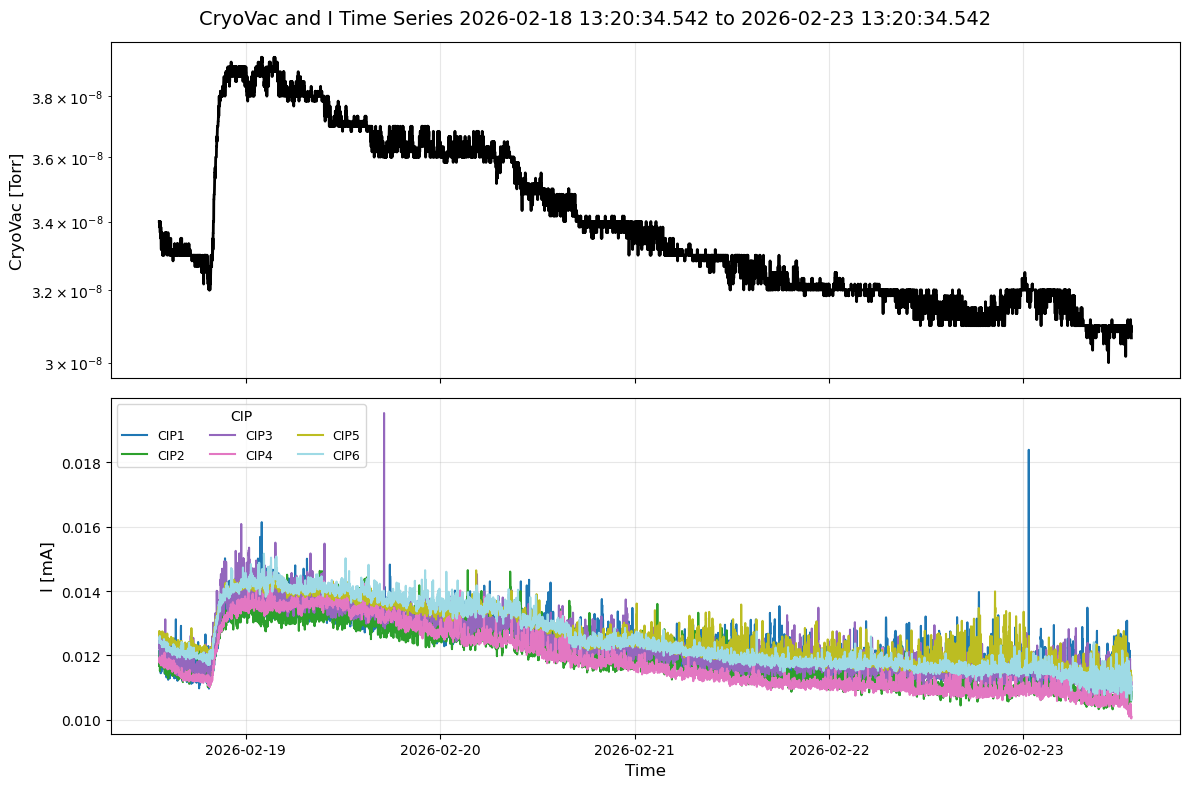

In [3]:
# Time-series plot: CryoVac and I for each CIP
if "df1" not in globals() or "df2" not in globals():
    raise RuntimeError("Run Cell 2 first to load df1/df2.")

df_cryo = df1.copy().rename(columns={"mean_CryoVac": "CryoVac"})
df_i = df2.copy().rename(columns={"mean_I": "I"})

required_df1 = {"CryoVac"}
required_df2 = {"I", "Cip"}
if df_cryo.empty or df_i.empty:
    raise ValueError("CryoVac or I data is empty. Check query results in Cell 2.")
if not required_df1.issubset(df_cryo.columns) or not required_df2.issubset(df_i.columns):
    raise KeyError(f"Missing required columns. df1={list(df_cryo.columns)}, df2={list(df_i.columns)}")

df_cryo = df_cryo.sort_index()
df_i = df_i.sort_index()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# CryoVac vs time
ax1.plot(df_cryo.index, df_cryo["CryoVac"], color="black", linewidth=2)
ax1.set_ylabel("CryoVac [Torr]", fontsize=12)
ax1.set_yscale("log")
ax1.grid(True, alpha=0.3)

# I vs time for each CIP
cips = sorted(df_i["Cip"].dropna().unique())
cmap = plt.get_cmap("tab20", len(cips))
for i, cip in enumerate(cips):
    sub = df_i[df_i["Cip"] == cip]
    y = sub["I"] - OFFSET.get(cip, 0.0)
    ax2.plot(sub.index, y, linewidth=1.5, color=cmap(i), label=f"{cip}")

ax2.set_ylabel("I [mA]", fontsize=12)
ax2.set_xlabel("Time", fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(title="CIP", ncol=3, fontsize=9)

plot_title = (
    f"CryoVac and I Time Series {t_start} to {t_end_iso}"
    if "t_start" in globals() and "t_end_iso" in globals()
    else "CryoVac and I Time Series"
 )
fig.suptitle(plot_title, fontsize=14)
plt.tight_layout()
plt.show()